In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"]
    #"font.family": "sans-serif",
    #"font.sans-serif": ["Computer Modern Serif"]
})
import tqdm
import sys
sys.path.append("../../")
from DynamicalSystems.kernels import RBF, Quadratic, Linear, Matern
from DynamicalSystems.reduced_rank_regression import KoopmanRegression
from DynamicalSystems.utils import plot_eigs
import seaborn as sns

def print_timescale(eigenvalues, stride, timestep, units=''):
    eps = 1e-12
    data = []
    for ev in eigenvalues:
        decay_length = np.around((-np.log(np.abs(ev))**-1)*stride*timestep, decimals = 2)
        if np.abs(np.imag(ev)) < eps:
            #Real eigenvalue
            freq = None
            data.append((decay_length, freq))
        else:
            #Imaginary eigenvalue
            freq = np.around(2*np.pi*(np.angle(ev)**-1)*stride*timestep, decimals=2)
            if freq > 0:
                data.append((decay_length, freq))
        
    col_width = max(len(str(_x[0]) + " " + units) for _x in data) + 2  # padding
    for x in data:
        if x[1] == None:
            print(f"Decay:{x[0]} {units}")
        else:
            a = str(x[0]) + " " + units
            print("Decay: " + a.ljust(col_width) + f"Frequency: {x[1]} {units}")


#### Standardizing dataset

In [2]:
df_pd = pd.read_pickle("full_dataframe").interpolate()
#Get stations and measurements 
stations = set()
measurements = set()
for col in df_pd.columns:
    meas, stat = col.split("_")
    measurements.add(meas)
    stations.add(stat)

standardizing_parameters = dict() # (std, mean)

for m in measurements:
    std = df_pd.filter(regex= m + "_*").std().mean()
    mean = df_pd.filter(regex= m + "_*").mean().mean()
    standardizing_parameters[m] = (std, mean)
    df_pd[df_pd.filter(regex= m + "_*").columns] -= mean
    df_pd[df_pd.filter(regex= m + "_*").columns] /= std
df = df_pd.filter(regex= "DEWP*").to_numpy()
#df = df_pd.to_numpy()

#### Selecting timestep, kernel, desired rank & regularizer

In [3]:
def subsample_data(df, n_timesteps, full_data=True, shift = 0):
    """Subsample the dataframe every timestep

    Args:
        df (np.ndarray): dataframe
        n_timesteps (int): number of original timesteps to skip because of subsamplign
        full_data (bool, optional): Retain full data or subsample only one of the possible n_timesteps subsequences. Defaults to True.
    """
    nan_mask = np.isnan(df).any(axis=1)
    dataset_indexes = []

    if full_data:
        for idx, val in enumerate(nan_mask[:-n_timesteps -shift]):
            if val == False:
                if nan_mask[idx + n_timesteps] == False:
                    dataset_indexes.append((idx, idx+ n_timesteps))
    else:
        
        for idx in range(int(df.shape[0]/n_timesteps)):
            try:
                _in = nan_mask[idx*n_timesteps] == False
                _out = nan_mask[(idx + 1)*n_timesteps] == False
                cond = _in and _out

                if shift > 0:
                    _in_shift = nan_mask[idx*n_timesteps + shift] == False
                    _out_shift = nan_mask[(idx + 1)*n_timesteps + shift] == False
                    cond_shift = _in_shift and _out_shift
                else:
                    cond_shift = True
                if cond and cond_shift:
                    dataset_indexes.append((idx*n_timesteps, (idx+1)*n_timesteps))
            except:
                pass                    

    dataset_indexes = np.array(dataset_indexes)
    if shift == 0:
        inputs = df[dataset_indexes[:,0]]
        evolved_inputs = df[dataset_indexes[:,1]]
    else:
        inputs = np.hstack([df[dataset_indexes[:,0] + i*shift] for i in range(2)])
        evolved_inputs = np.hstack([df[dataset_indexes[:,1] + i*shift] for i in range(2)])
    return inputs, evolved_inputs

In [4]:
n_timesteps = 1 #In hours
rank = 10
regularizer = 1e-5
l = np.float32(np.sqrt(df.shape[1]))
X, Y = subsample_data(df, n_timesteps, full_data=False, shift=6)
nu = 1.5
kernel = RBF(length_scale=l)
num_samples = 2000

In [9]:
K = KoopmanRegression(X[:num_samples], Y[:num_samples], kernel, rank, regularizer, center_kernel=True, backend='cpu')

INIT: Computing low-rank-projection


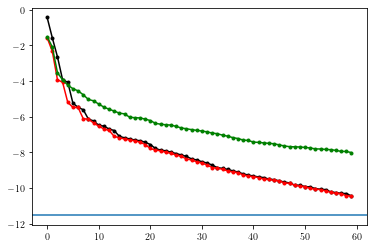

In [10]:
dim = K.X.shape[0]
padding = 50
e_X = (np.linalg.eigvalsh(K.K_X)*(dim**-1))[::-1][:rank + padding]
e_Y = (np.linalg.eigvalsh(K.K_Y)*(dim**-1))[::-1][:rank + padding]
e_YX = (np.linalg.eigvalsh(K.K_YX)*(dim**-1))[::-1][:rank + padding]
plt.plot(np.log(e_X), 'k.-')
plt.plot(np.log(e_Y), 'r.-')
plt.plot(np.log(e_YX), 'g.-')
plt.axhline(y=np.log(regularizer))

In [11]:
eigs, lv, rv = K.eig()

Decay: 5.16 Hours   Frequency: 61.46 Hours
Decay:4.89 Hours
Decay:6.26 Hours
Decay: 11.51 Hours  Frequency: 94.72 Hours
Decay: 22.55 Hours  Frequency: 142.51 Hours
Decay:76.63 Hours
Decay:31.52 Hours


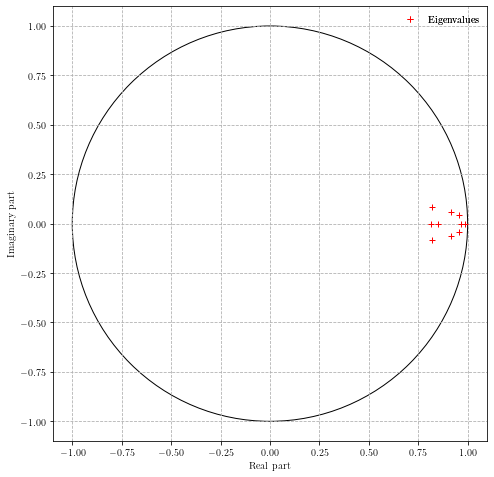

<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

In [12]:
print_timescale(eigs, n_timesteps, 1, 'Hours')
plot_eigs(eigs)

In [ ]:
import seaborn as sns
ax = sns.displot(df_pd.filter(regex="PM2.5_*"), kind='kde', fill=True)

#### Sine wave

In [ ]:
x = np.arange(0,10,0.01)
f = 2
y = np.sin(f*x)[:, np.newaxis]
_y = np.sin(f*x)
shift = 50
y_shift = np.empty((x.shape[0] -shift,2), dtype = x.dtype)
y_shift[:,0] = _y[:-shift]
y_shift[:,1] = _y[shift:]
kernel_RBF = RBF(length_scale=1)
kernel_linear = Linear(coef0=0.)
regularizer = 1e-6

In [ ]:
K = kernel_RBF.to_numpy(y[:-1])
K_shift = kernel_RBF.to_numpy(y_shift[:-1])

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize=(7,3))
ax[0].matshow(K, cmap='Greys')
ax[1].matshow(K_shift, cmap='Greys')
ax[0].set_title("Normal")
ax[1].set_title("Shifted")

In [ ]:
evals, evecs = reduced_rank_regression(y_shift[:-1], y_shift[1:], kernel_RBF, 8, regularizer)

In [ ]:
plot_eigs(evals)
print(np.imag(implied_timescale(evals,1,0.01)))

In [ ]:
implied_timescale(evals,1,0.01)

In [ ]:
K = kernel_RBF.to_numpy(y)
K_L = kernel_linear.to_numpy(y)

In [ ]:
plt.matshow(K)
plt.colorbar()